In [ ]:
'''using torchvision for dataloading'''
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from psutil import cpu_count
from torchvision import transforms
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from helpers import calculate_accuracy, initialize_mobilenet_weights

%matplotlib widget

'''strikes are 1, ballss are 2 since we pad with 0s and cross entropy loss has to ignore something.'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparameters
learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 2 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 2000
eval_interval = 50
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
use_autocast = False

#annotations paths
train_annotations_file = '/workspace/picklebotdataset/train_labels.csv'
val_annotations_file = '/workspace/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

#annotations paths
train_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train_labels.csv'
val_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val/'

#establish our normalization using transforms
transform = transforms.Normalize((0.5,), (0.5,))

#dataset     
train_dataset = PicklebotDataset(train_annotations_file,train_video_paths,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())
val_dataset = PicklebotDataset(val_annotations_file,val_video_paths,transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())

#model, optimizer, loss function
model = MobileNetSmall3D().to(device)

#initialize weights
initialize_mobilenet_weights(model)

#for multi-gpu
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_lambda' 

@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    correct_predictions = 0

    #calculate the loss
    for val_features,val_labels in val_loader:
        val_features = val_features.to(device)
        val_labels = val_labels.to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        
        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels.to(device))
        
        total_val_loss += val_loss.item()
        
        num_val_batches += 1        
        
        correct_predictions += calculate_accuracy(val_outputs,val_labels)
    
    avg_val_loss = total_val_loss / num_val_batches
    val_accuracy = correct_predictions / len(val_loader.dataset)
    return avg_val_loss, val_accuracy





#try except block so we can manually early stop while saving the model
#training loop
start_time = time.time()
train_losses = []
train_percent = []
val_losses = []
val_percent = []


#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()


try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        #forward pass
        for batch_idx, (features,labels) in tqdm(enumerate(train_loader)):
            
            labels = labels.to(torch.int64)
            features = features.to(device)
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
        if use_autocast:    
            with autocast():
                outputs = model(features)
                loss = criterion(outputs,labels.to(device))
            
            #backprop & update weights

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            outputs = model(features)
            loss = criterion(outputs,labels.to(device))

            #backprop & update weights
            loss.backward()
            optimizer.step()
        

        batch_correct = calculate_accuracy(outputs,labels)
        train_correct += batch_correct
        train_samples += len(labels)

        if iter % eval_interval == 0 or iter == max_iters - 1:
            
            #evaluate the model
            train_losses.append(loss.item()) #loss of the last batch
            train_percent.append(train_correct / train_samples)
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val batch
            val_percent.append(val_accuracy) #percent of correct predictions in the val batch

            print(f"step {iter}: train loss:  {loss:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, eval accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)


        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()

[/opt/dali/dali/operators/reader/loader/video_loader.h:179] ``file_list_include_preceding_frame`` uses the default value False. In future releases, the default value will be changed to True.
[/opt/dali/dali/operators/reader/loader/video_loader.h:179] ``file_list_include_preceding_frame`` uses the default value False. In future releases, the default value will be changed to True.
/home/hankhome/mambaforge/lib/python3.10/site-packages/nvidia/dali/plugin/base_iterator.py:191: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
69it [00:04, 16.83it/s]
/opt/conda/conda-bld/pytorch_1685344476172/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


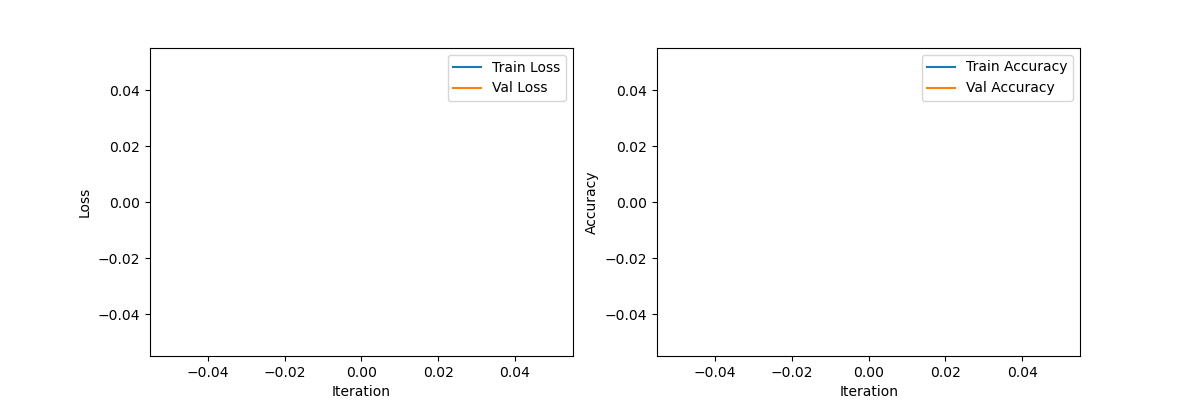

In [1]:
'''This version of the program uses Nvidia Dali to load data, not torchvision.io.read_video,
   It should be substantially faster, especially with multiple gpus, perhaps a good setup 
   would be one to load the videos, one to run the training loop?

    Eventually, this and the other version in this notebook should be merged into one notebook, with a flag to choose which to use.
   
'''
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
from tqdm import tqdm
from psutil import cpu_count
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from helpers import calculate_accuracy, initialize_mobilenet_weights 

%matplotlib widget

'''Balls are 1, strikes are 2 since we pad with 0s and cross entropy loss has to ignore our padding'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters
learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 2 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 2000
eval_interval = 50
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
use_autocast = True

#information for the dali pipeline
sequence_length = 276 #longest videos in our dataset
initial_prefetch_size = 1

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val/'
num_train_videos = len(train_video_paths + '/' + 'balls') + len(train_video_paths + '/' + 'strikes')
num_val_videos = len(val_video_paths + '/' + 'balls') + len(val_video_paths + '/' + 'strikes')

#define our model, initialize
model = MobileNetSmall3D().to(device)
initialize_mobilenet_weights(model)

#for multi-gpu setups 
#may want to revisit this and choose which device we use for loading with dali, and which to use for training the net.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

#define our optimizer
#optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_cloud' 

#define our pipeline
@pipeline_def
def video_pipeline(file_root):
    videos, labels = fn.readers.video(device="gpu", file_root=file_root, sequence_length=sequence_length,
                              shard_id=0, num_shards=1, random_shuffle=True, initial_fill=initial_prefetch_size,pad_sequences=True)
    return videos, labels

#estimate_loss using validation set, we should refactor this.
@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    correct_predictions = 0

    #calculate the loss
    for i,val_features in tqdm(enumerate(val_loader)):
        val_features = val_features[0]['data']/255
        val_features = val_features.permute(0,-1,1,2,3)
        val_labels = (val_features[0]['label'] + 1).view(-1).to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        
        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels)
        
        total_val_loss += val_loss.item()
        
        num_val_batches += 1        
        
        correct_predictions += calculate_accuracy(val_outputs,val_labels)
    
    avg_val_loss = total_val_loss / num_val_batches
    val_accuracy = correct_predictions / len(val_loader.dataset)
    return avg_val_loss, val_accuracy


#initialize lists for plotting
start_time = time.time()
train_losses = []
train_percent = []
val_losses = []
val_percent = []

#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()


#sadly, we have to establish two pipelines, one val and one train.
train_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=train_video_paths)
val_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=val_video_paths)

train_pipe.build()
val_pipe.build()


train_loader = DALIClassificationIterator(train_pipe, size=num_train_videos,auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL)
val_loader = DALIClassificationIterator(train_pipe, size=num_val_videos,auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL)

try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        #forward pass
        for batch_idx, features in tqdm(enumerate(train_loader)):
            
            labels = (features[0]['label']+1).view(-1).to(torch.int64)
            features = features[0]['data']/255 #i think it makes sense to overwrite features to save precious gpu memory
            features = features.permute(0,-1,1,2,3)
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
        if use_autocast:    
            with autocast():
                outputs = model(features)
                loss = criterion(outputs,labels)
            
            #backprop & update weights

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            outputs = model(features)
            loss = criterion(outputs,labels)

            #backprop & update weights
            loss.backward()
            optimizer.step()
        

        batch_correct = calculate_accuracy(outputs,labels)
        train_correct += batch_correct
        train_samples += len(labels)

        if iter % eval_interval == 0 or iter == max_iters - 1:
            
            #evaluate the model
            train_losses.append(loss.item()) #loss of the last batch
            train_percent.append(train_correct / train_samples)
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val batch
            val_percent.append(val_accuracy) #percent of correct predictions in the val batch

            print(f"step {iter}: train loss:  {loss:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, eval accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)


        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()